In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
os.chdir('/content/drive/MyDrive/Saad')  # Change to your folder path

In [3]:
!pip install diffusers transformers accelerate
!pip install torch torchvision
!pip install datasets
!pip install ftfy regex tqdm
!pip install matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTokenizer, CLIPTextModel
from accelerate import Accelerator
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [5]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [18]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, captions, transform=None):
        self.image_folder = image_folder
        self.captions = captions
        self.transform = transform
        self.image_files = os.listdir(image_folder)
        print(f"Number of images: {len(self.image_files)}")
        print(f"Number of captions: {len(self.captions)}")


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        caption = self.captions[idx]
        if self.transform:
            image = self.transform(image)
        return image, caption



In [19]:
# Define your captions
captions = [
    "A selfie picture of Saad with his front pose",
    "A picture of saad in green dress, he is angry",
    "A sad picture of Saad",
    "Saad in his formal attire"
    "A picture of Saad looking at his wrist watch",
    "A picture of Saad in dark light",
    "A picture of Saad in blue dress",
    "A picture of Saad while he is delivering a speech",
    "A picture of Saad front facing",
    "A picture of saad looking upwards"
    "A happy picture of Saad",
    "A picture of Saad standing with hands in pocket of pants"
    # Add more captions corresponding to each image
]

# Initialize dataset and dataloader
dataset = CustomDataset(image_folder='/content/drive/MyDrive/Saad', captions=captions, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

Number of images: 12
Number of captions: 10


In [20]:
accelerator = Accelerator(mixed_precision="fp16")
model_id = "CompVis/stable-diffusion-v1-4"
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to(accelerator.device)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(accelerator.device)
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder").to(accelerator.device)
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")

In [16]:
# Training loop with gradient accumulation
num_epochs=1
for epoch in range(num_epochs):
    for step, (images, captions) in enumerate(dataloader):
        # Move images to the correct device
        images = images.to(accelerator.device)

        latents = vae.encode(images).latent_dist.sample()
        latents = latents * vae.config.scaling_factor

        # Get text embeddings
        text_inputs = tokenizer(captions, padding="max_length", return_tensors="pt").input_ids.to(accelerator.device)
        text_embeddings = text_encoder(text_inputs)[0]

        # Forward pass through UNet
        model_output = unet(latents, timestep=torch.tensor([1], device=accelerator.device), encoder_hidden_states=text_embeddings).sample

NameError: name 'self' is not defined

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

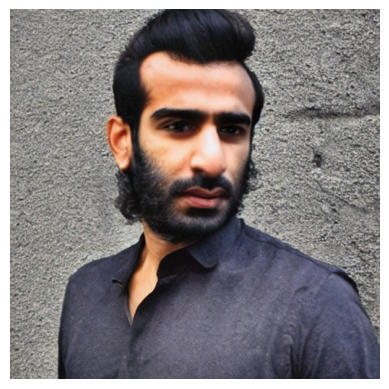

  0%|          | 0/50 [00:00<?, ?it/s]

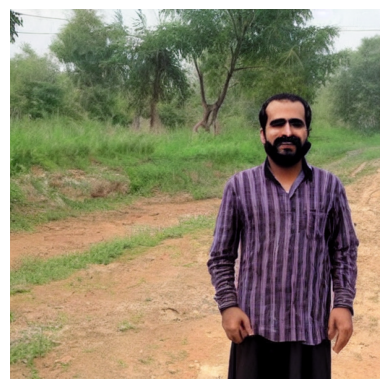

  0%|          | 0/50 [00:00<?, ?it/s]

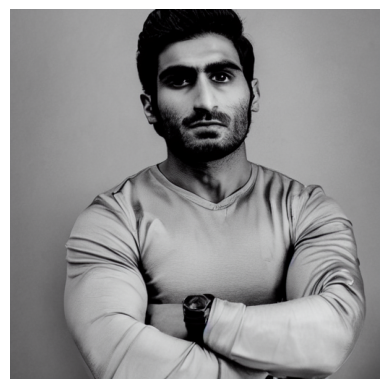

  0%|          | 0/50 [00:00<?, ?it/s]

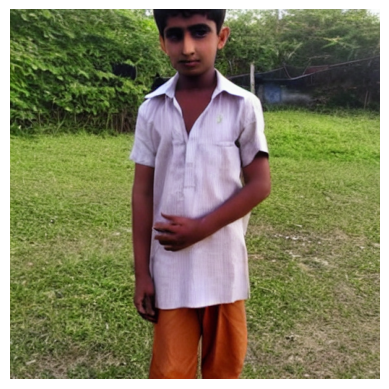

  0%|          | 0/50 [00:00<?, ?it/s]

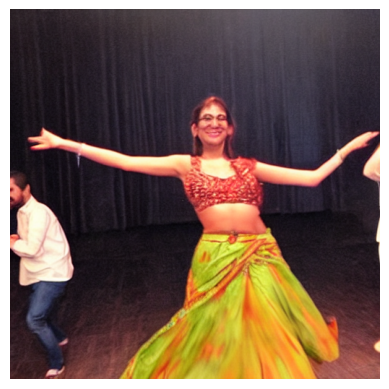

In [ ]:
pipeline = StableDiffusionPipeline.from_pretrained(model_id, text_encoder=text_encoder, vae=vae, unet=unet).to("cuda")

prompts = [
    "Saad in long hair, and a side pose",
    "A picture of Saad in rural area",
    "A picture of Saad posing",
    "A side pose picture of Saad as a village boy",
    "A picture of Saad happily dancing"
]

for prompt in prompts:
    generated_image = pipeline(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()


In [ ]:
# prompt: clear cuda space

import torch
torch.cuda.empty_cache()
